# Localize Marketing Content with Amazon Bedrock

Life science companies need to reach ever-smaller groups of customers with tailored marketing content. However, it's expensive and time-consuming to manually create, review, and approve personalized content at scale. Generative AI has the potential to help. However, automated content generation must produce factual information that meets all regulatory requirements.


-----
## 0. (One-Time Only) Install Amazon Bedrock dependencies

If you haven't yet, install the limited preview versions of boto3. Note: Replace the .whl file paths in the next cell to the location of your preview-version files

In [ ]:
# !bash ./download-dependencies.sh

# import glob, subprocess, sys

# for path in glob.glob("dependencies/*.whl"):
#     subprocess.check_call([sys.executable, "-m", "pip", "install", path])

In [ ]:
%pip install langchain pillow

-----
## 1. Setup Bedrock client

In [3]:
import boto3
from time import sleep
from pprint import pprint

boto_session = boto3.Session()
bedrock = boto_session.client("bedrock")

bedrock_models = [
    model["modelId"] for model in bedrock.list_foundation_models().get("modelSummaries")
]
bedrock_models.sort()
pprint(bedrock_models)

['ai21.j2-grande-instruct',
 'ai21.j2-jumbo-instruct',
 'ai21.j2-mid',
 'ai21.j2-ultra',
 'amazon.titan-e1t-medium',
 'amazon.titan-tg1-large',
 'anthropic.claude-instant-v1',
 'anthropic.claude-v1',
 'anthropic.claude-v2',
 'stability.stable-diffusion-xl']


-----
## 2. Load Source Text

OTC drug label information for generic Ibuprofen downloaded and extracted from [NIH DailyMed](https://dailymed.nlm.nih.gov/dailymed/drugInfo.cfm?setid=ef6981ed-ed98-7283-e053-2a95a90a4c64).

In [25]:
label_info = """Ibuprofen Drug Facts
Active Ingredients (in each tablet): Ibuprofen 200 mg (NSAID
Purpose: Pain reliever / fever reducer
Uses: Temporarily relieves minor aches and pains due to:
- headache
- toothache
- backache
- menstrual cramps
- the common cold
- muscular aches
- minor pain of arthritis
- temporarily reduces fever

Warnings: 
Allergy alert
Ibuprofen may cause a severe allergic reaction, especially in people allergic to aspirin.
Symptoms may include:
- hives
- facial swelling
- asthma (wheezing)
- shock
- skin reddening
- rash
- blisters

If an allergic reaction occurs, stop use and seek medical help right away.

Stomach bleeding warning
This product contains an NSAID, which may cause severe stomach bleeding. The chance
is higher if you:
- are age 60 or older
- have had stomach ulcers or bleeding problems
- take a blood thinning (anticoagulant) or steroid drug
- take other drugs containing prescription or nonprescription NSAIDs (aspirin, ibuprofen, naproxen, or others)
- have 3 or more alcoholic drinks every day while using this product
- take more or for a longer time than directed

Heart attack and stroke warning
NSAIDs, except aspirin, increase the risk of heart attack, heart failure, and stroke. These
can be fatal. The risk is higher if you use more than directed or for longer than directed.
Do not use if you have ever had an allergic reaction to any other pain reliever/fever reducer
right before or after heart surgery.
"""

-----
## 3. Generate marketing headline text with Anthropic Claude Instant

In [26]:
drug_name = "AnyDrug"

headline_prompt_data = """
	Human:
	You are a highly skilled language model designed to write effective marketing content. 
	You are responsible for generating marketing content for a new new drug named "{0}". 
	I will give you a description of the product surrounded by <description></description> tags. 
	Based on this input, create a one-sentence headline about {0} that conveys good health and excitement.

	The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "\`\`\`json" and "\`\`\`":

    ```json
	{{
		'text': string  // This is your response.
	}}
    ```

	<description>
    {1}
    </description>


	Assistant:
""".format(
    drug_name, label_info
)

In [27]:
import json
from langchain.output_parsers.json import parse_json_markdown

modelId = "anthropic.claude-instant-v1"
body = json.dumps(
    {
        "prompt": headline_prompt_data,
        "max_tokens_to_sample": 64,
        "temperature": 0.7,
        "stop_sequences": ["\n\nHuman:"],
    }
)

response = bedrock.invoke_model(
    body=body,
    modelId=modelId,
    accept="application/json",
    contentType="application/json",
)
response_body = json.loads(response.get("body").read())
marketing_headline = parse_json_markdown(response_body.get("completion")).get("text")
print(marketing_headline)

Feel relief and ease your aches and pains with powerful AnyDrug.


-----
## 4. Generate marketing body text with Anthropic Claude

In [35]:
drug_name = "AnyDrug"

body_prompt_data = """
	Human:
	You are a highly skilled language model designed to write effective marketing content. 
	You are responsible for generating marketing content for a new new drug named "{0}". 
	I will give you a description of the product surrounded by <description></description> tags. 
	Based on this input, write a short paragraph describing the product benefits and why people should use it. 
    The description should be upbeat and make people feel like this product will make their life better. Be sure to include a description of any potential side effects or other warnings.
    End the description by instructing the reader to ask their doctor about the product.

	The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "\`\`\`json" and "\`\`\`":

    ```json
	{{
		'text': string  // This is your response.
	}}
    ```

	<description>
    {1}
    </description>


	Assistant:
""".format(
    drug_name, label_info
)

In [36]:
import json
from json_parser import parse_json_markdown

body = json.dumps(
    {
        "prompt": body_prompt_data,
        "max_tokens_to_sample": 512,
        "temperature": 0.25,
        "stop_sequences": ["\n\nHuman:"],
    }
)

response = bedrock.invoke_model(
    body=body,
    modelId=modelId,
    accept="application/json",
    contentType="application/json",
)
response_body = json.loads(response.get("body").read())
marketing_body = parse_json_markdown(response_body.get("completion")).get("text")
print(marketing_body)

AnyDrug is a powerful pain reliever that can help you get relief fast. It works to reduce minor aches and pains so you can get back to your normal activities. Any side effects are typically mild and may include stomach upset, headache or drowsiness. AnyDrug is safe and effective when used as directed, but consult your doctor to determine if it is right for you. Ask your doctor if AnyDrug may be right for you.


## 5. Assemble content for the United States

In [37]:
def assemble_ad(brand_name, marketing_headline, marketing_body, image):
    from PIL import Image, ImageDraw, ImageFont
    import textwrap

    layout_width = 768
    layout_height = 994
    layout = Image.new("RGB", (layout_width, layout_height), (32, 39, 53))
    layout.paste(image, (0, 0))
    logo = Image.open("assets/images/AWS_logo_RGB_WHT.png")
    layout.paste(logo, (650, 925), logo)

    drawing = ImageDraw.Draw(layout)

    drawing.ellipse(
        xy=[(0, 423), (768, 473)], outline=(32, 39, 53), fill=(32, 39, 53), width=1
    )

    headline_line_length = 30
    wrapped_headline = "\n".join(
        textwrap.wrap(marketing_headline, width=headline_line_length)
    ).strip()
    drawing.multiline_text(
        xy=(50, 475),
        text=wrapped_headline,
        fill=(255, 255, 255),
        font=ImageFont.truetype("assets/fonts/AmazonEmber_Bd.ttf", 42),
    )

    body_line_length = 72
    wrapped_body = "\n".join(
        textwrap.wrap(marketing_body, width=body_line_length)
    ).strip()

    drawing.multiline_text(
        xy=(50, 650),
        text=wrapped_body,
        fill=(255, 255, 255),
        font=ImageFont.truetype("assets/fonts/AmazonEmber_Rg.ttf", 20),
    )
    drawing.text(
        xy=(50, 925),
        text=brand_name,
        fill=(255, 255, 255),
        font=ImageFont.truetype("assets/fonts/AmazonEmber_Bd.ttf", 32),
    )

    drawing.text(
        xy=(50, 965),
        text="(imaginariam medicinam)",
        fill=(255, 255, 255),
        font=ImageFont.truetype("assets/fonts/AmazonEmber_Rg.ttf", 12),
    )

    return layout

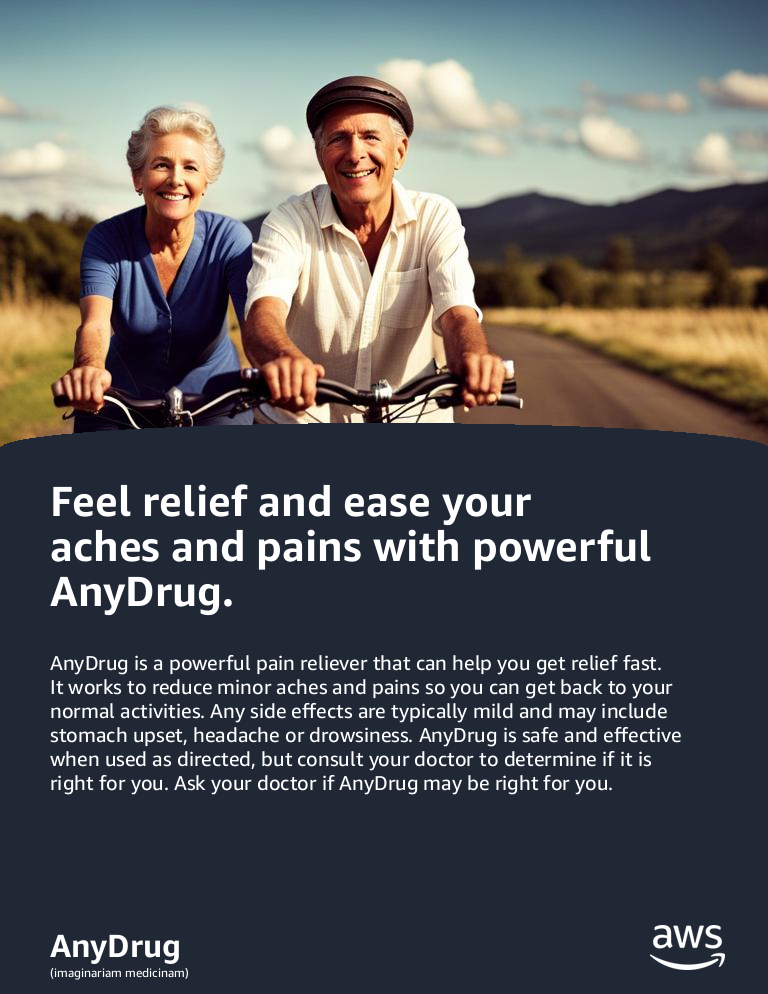

In [38]:
from PIL import Image

image = Image.open("assets/images/src-image.jpg")
assemble_ad(drug_name, marketing_headline, marketing_body, image)

-----
## 6. Localize Stock Image with Stable Diffusion

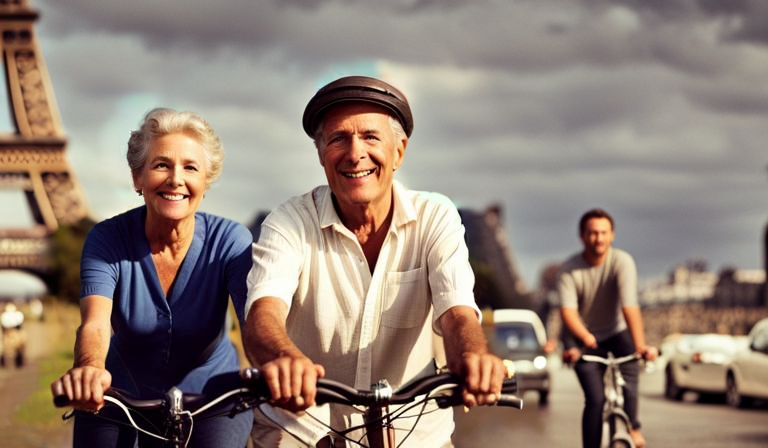

In [39]:
from PIL import Image
from io import BytesIO
import base64
import json
from botocore.exceptions import ClientError


def modify_image(image, image_prompt, bedrock_client, image_mask = None, style="cinematic"):
    init_image = Image.open(image)
    buffer = BytesIO()
    init_image.save(buffer, format="PNG")
    init_image_bytestring = base64.b64encode(buffer.getvalue()).decode()



    body_dict = {
            "text_prompts": [
                {"text": image_prompt, "weight": 1},
                {"text": "deformed, low quality", "weight": -1},
            ],
            "seed": 42,
            "init_image": init_image_bytestring,
            "style_preset": style,
        }
    
    if image_mask is not None:
        mask = Image.open(image_mask)
        buffer = BytesIO()
        mask.save(buffer, format="PNG")
        mask_bytestring = base64.b64encode(buffer.getvalue()).decode()

        body_dict['mask_source'] = "MASK_IMAGE_BLACK"
        body_dict['mask_image'] = mask_bytestring

    body = json.dumps(body_dict)
    modelId = "stability.stable-diffusion-xl"

    try:
        response = bedrock_client.invoke_model(
            body=body, modelId=modelId, contentType="application/json"
        )
    except ClientError as error:
        print(error.response)
    response = json.loads(response.get("body").read())

    if response.get("result") == "error":
        raise Exception(response.get("error"))

    images = response.get("artifacts")

    image = Image.open(BytesIO(base64.b64decode(images[0].get("base64"))))
    return image


prompt_data = "Riding bicycles in Paris, France."
init_image = "assets/images/src-image.jpg"
mask_image = "assets/images/src-image-mask.png"
localized_image = modify_image(init_image, prompt_data, bedrock, image_mask=mask_image)
localized_image.save("assets/images/generated-image-paris.jpg")
display(localized_image)

-----
## 7. Translate text with Amazon Translate

In [40]:
import re


def translate_text(text, brand_name, country_code):

    translate = boto_session.client(service_name="translate")
    annotated_text = text.replace(brand_name, f"<p translate=no>{brand_name}</p>")
    src = "en"
    dest = country_code
    translated_text = (
        translate.translate_text(
            Text=annotated_text,
            SourceLanguageCode=src,
            TargetLanguageCode=dest,
        )
        .get("TranslatedText", "NA")
        .replace("\xa0", "")
        .strip()
    )
    pattern = re.compile("<.*?>")
    return re.sub(pattern, "", translated_text)


localized_marketing_headline = translate_text(marketing_headline, drug_name, "fr")
print(localized_marketing_headline)

localized_marketing_body = translate_text(marketing_body, drug_name, "fr")
print(localized_marketing_body)

Ressentez un soulagement et soulagez vos courbatures grâce à de puissantsAnyDrug.
AnyDrugest un puissant analgésique qui peut vous aider à obtenir un soulagement rapide. Il agit pour réduire les courbatures et les douleurs mineures afin que vous puissiez reprendre vos activités normales. Les effets secondaires sont généralement légers et peuvent inclure des maux d'estomac, des maux de tête ou de la somnolence. AnyDrugest sûr et efficace lorsqu'il est utilisé conformément aux instructions, mais consultez votre médecin pour déterminer s'il vous convient. Demandez à votre médecin si cela AnyDrug peut vous convenir.


-----
## 8. Assemble localized content

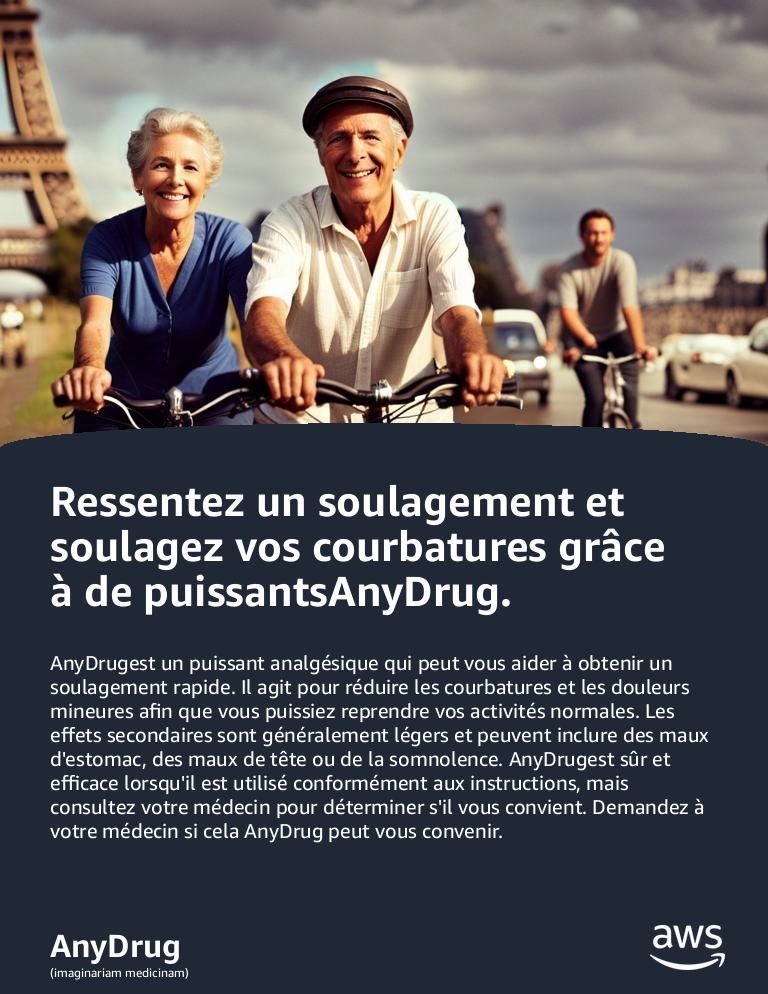

In [41]:
assemble_ad(
    drug_name, localized_marketing_headline, localized_marketing_body, localized_image
)